In [1]:
%matplotlib inline

Quickstart tutorial
===================

In this introductory example, you will see how to use SpikeInterface to perform a full electrophysiology analysis.
We will download a simulated dataset, and we will then perform some pre-processing, run a spike sorting
algorithm, post-process the spike sorting output, perform curation (manual and automatic), and compare spike sorting results.

In [2]:
import matplotlib.pyplot as plt
from pprint import pprint

The spikeinterface module by itself imports only the spikeinterface.core submodule
which is not useful for the end user

In [3]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are several modules:

- `extractors` : file IO
- `preprocessing` : preprocessing
- `sorters` : Python wrappers of spike sorters
- `postprocessing` : postprocessing
- `qualitymetrics` : quality metrics on units found by sorters
- `curation` : automatic curation of spike sorting output
- `comparison` : comparison of spike sorting outputs
- `widgets` : visualization

In [4]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw

Alternatively, we can import all submodules at once with `import spikeinterface.full as si` which
internally imports core+extractors+preprocessing+sorters+postprocessing+
qualitymetrics+comparison+widgets+exporters. In this case all aliases in the following tutorial
would be `si`.

This is useful for notebooks, but it is a heavier import because internally many more dependencies
are imported (scipy/sklearn/networkx/matplotlib/h5py...)

In [5]:
import spikeinterface.full as si

Before getting started, we can set some global arguments for parallel processing. For this example, let's use 4 jobs and time chunks of 1s:

In [6]:
global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

First, let's download a simulated dataset from the
https://gin.g-node.org/NeuralEnsemble/ephy_testing_data repo
We download the dataset using DataLad but it can also be downloaded directly.

Then we can open it. Note that [MEArec](https://mearec.readthedocs.io) simulated files
contain both a "recording" and a "sorting" object.

In [7]:
local_path = si.download_dataset(remote_path="mearec/mearec_test_10s.h5")
recording, sorting_true = se.read_mearec(local_path)
print(recording)
print(sorting_true)

 modified: mearec\mearec_test_10s.h5 (file)
1 annex'd file (59.4 MB recorded total size)
MEArecRecordingExtractor: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                          float32 dtype - 39.06 MiB
  file_path: C:\Users\NTELAB\spikeinterface_datasets\ephy_testing_data\mearec\mearec_test_10s.h5
MEArecSortingExtractor: 10 units - 1 segments - 32.0kHz
  file_path: C:\Users\NTELAB\spikeinterface_datasets\ephy_testing_data\mearec\mearec_test_10s.h5


`recording` is a `BaseRecording` object, which extracts information about
channel ids,  channel locations (if present), the sampling frequency of the recording, and the extracellular
traces. `sorting_true` is a `BaseSorting` object, which contains information
about spike-sorting related information,  including unit ids, spike trains, etc. Since the data are simulated,
`sorting_true` has ground-truth information of the spiking activity of each unit.

Let's use the `spikeinterface.widgets` module to visualize the traces and the raster plots.

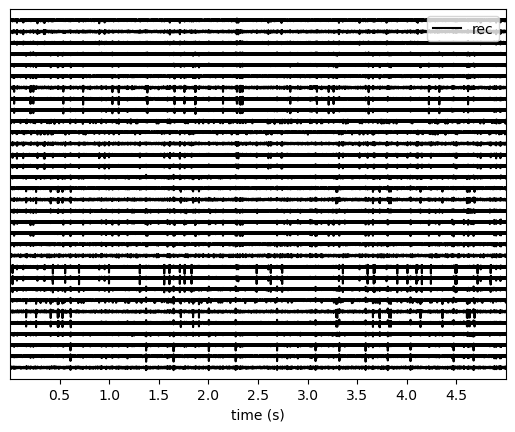

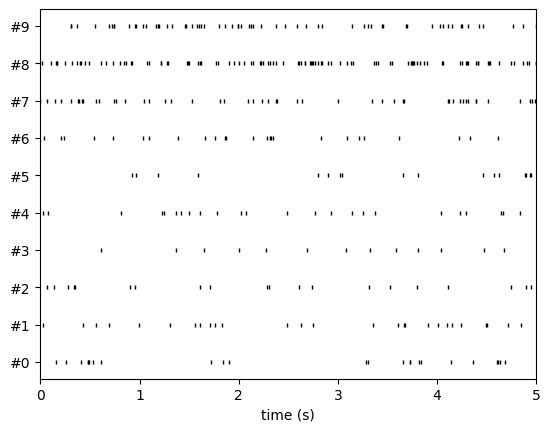

In [8]:
w_ts = sw.plot_traces(recording, time_range=(0, 5))
w_rs = sw.plot_rasters(sorting_true, time_range=(0, 5))

This is how you retrieve info from a `BaseRecording`...

In [9]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()

print("Channel ids:", channel_ids)
print("Sampling frequency:", fs)
print("Number of channels:", num_chan)
print("Number of segments:", num_seg)

Channel ids: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32']
Sampling frequency: 32000.0
Number of channels: 32
Number of segments: 1


...and from a `BaseSorting`

In [10]:
num_seg = recording.get_num_segments()
unit_ids = sorting_true.get_unit_ids()
spike_train = sorting_true.get_unit_spike_train(unit_id=unit_ids[0])

print("Number of segments:", num_seg)
print("Unit ids:", unit_ids)
print("Spike train of first unit:", spike_train)

Number of segments: 1
Unit ids: ['#0' '#1' '#2' '#3' '#4' '#5' '#6' '#7' '#8' '#9']
Spike train of first unit: [  5197   8413  13124  15420  15497  15668  16929  19607  55107  59060
  60958 105193 105569 117082 119243 119326 122293 122877 132413 139498
 147402 147682 148271 149857 165454 170569 174319 176237 183598 192278
 201535 217193 219715 221226 222967 223897 225338 243206 243775 248754
 253184 253308 265132 266197 266662 283149 284716 287592 304025 305286
 310438 310775 318460]


SpikeInterface internally uses the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/) package to handle `probeinterface.Probe` and
`probeinterface.ProbeGroup`. So any probe in the probeinterface collection can be downloaded and set to a
`Recording` object. In this case, the MEArec dataset already handles a `Probe` and we don't need to set it *manually*.

Probe - 32ch - 1shanks


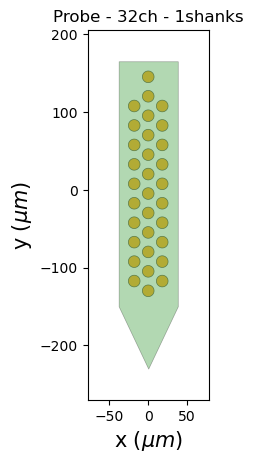

In [11]:
probe = recording.get_probe()
print(probe)

from probeinterface.plotting import plot_probe

_ = plot_probe(probe)

If your recording does not have a `Probe`, you can set it using `set_probe`.
Note: `set_probe` creates a copy of the recording with the new probe,
rather than modifying the existing recording in place.
There is more information [here](https://spikeinterface.readthedocs.io/en/latest/modules_gallery/core/plot_3_handle_probe_info.html).

Using the `spikeinterface.preprocessing` module, you can perform preprocessing on the recordings.
Each pre-processing function also returns a `BaseRecording`,
which makes it easy to build pipelines. Here, we filter the recording and apply common median reference (CMR).
All these preprocessing steps are "lazy". The computation is done on demand when we call
`recording.get_traces(...)` or when we save the object to disk.

In [12]:
recording_cmr = recording
recording_f = si.bandpass_filter(recording, freq_min=300, freq_max=6000)
print(recording_f)
recording_cmr = si.common_reference(recording_f, reference="global", operator="median")
print(recording_cmr)

# this computes and saves the recording after applying the preprocessing chain
recording_preprocessed = recording_cmr.save(format="binary")
print(recording_preprocessed)

BandpassFilterRecording: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                         float32 dtype - 39.06 MiB
CommonReferenceRecording: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                          float32 dtype - 39.06 MiB
Use cache_folder=C:\Users\NTELAB\AppData\Local\Temp\spikeinterface_cache\tmpxqi05p22\VJJ4J675
write_binary_recording 
n_jobs=4 - samples_per_chunk=32,000 - chunk_memory=3.91 MiB - total_memory=15.62 MiB - chunk_duration=1.00s


write_binary_recording:   0%|          | 0/10 [00:00<?, ?it/s]

BinaryFolderRecording: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                       float32 dtype - 39.06 MiB


To reload a preprocessed recording that was saved to disk, you can use `load_extractor()` function from the `core` module.

Now you are ready to spike sort using the `spikeinterface.sorters` module!
Let's first check which sorters are implemented and which are installed

In [13]:
print("Available sorters", ss.available_sorters())
print("Installed sorters", ss.installed_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'kilosort4', 'klusta', 'mountainsort4', 'mountainsort5', 'pykilosort', 'simple', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']
Installed sorters ['simple', 'spykingcircus2', 'tridesclous', 'tridesclous2']


The `ss.installed_sorters()` will list the sorters installed on the machine.
We can see we have HerdingSpikes and Tridesclous installed.
Spike sorters come with a set of parameters that users can change.
The available parameters are dictionaries and can be accessed with:

In [14]:
print("Tridesclous params:")
pprint(ss.get_default_sorter_params("tridesclous"))
print("SpykingCircus2 params:")
pprint(ss.get_default_sorter_params("spykingcircus2"))

Tridesclous params:
{'chunk_duration': '1s',
'common_ref_removal': False,
'detect_sign': -1,
'detect_threshold': 5,
'freq_max': 5000.0,
'freq_min': 400.0,
'max_threads_per_process': 1,
'mp_context': None,
'n_jobs': 4,
'nested_params': None,
'progress_bar': True}
SpykingCircus2 params:
{'apply_motion_correction': True,
'apply_preprocessing': True,
'cache_preprocessing': {'delete_cache': True,
'memory_limit': 0.5,     
'mode': 'memory'},       
'clustering': {'legacy': True},
'debug': False,
'detection': {'detect_threshold': 4, 'peak_sign': 'neg'},
'filtering': {'filter_order': 2,
'freq_max': 7000,
'freq_min': 150,
'ftype': 'bessel'},
'general': {'ms_after': 2, 'ms_before': 2, 'radius_um': 100},
'job_kwargs': {'n_jobs': 0.8},
'matched_filtering': True,
'matching': {'method': 'wobble'},
'merging': {'auto_merge': {'corr_diff_thresh': 0.25, 'min_spikes': 10},
'correlograms_kwargs': {},
'similarity_kwargs': {'max_lag_ms': 0.2,
'method': 'cosine',                
'support': 'union'}},        

Let's run `tridesclous` and change one of the parameters, say, the `detect_threshold`:

In [15]:
sorting_TDC = ss.run_sorter(sorter_name="tridesclous", recording=recording_preprocessed, detect_threshold=4)
print(sorting_TDC)

C:\Users\NTELAB\.conda\envs\si_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\NTELAB\.conda\envs\si_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\NTELAB\.conda\envs\si_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\NTELAB\.conda\envs\si_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\NTELAB\.conda\envs\si_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

TridesclousSortingExtractor: 10 units - 1 segments - 32.0kHz


Alternatively we can pass a full dictionary containing the parameters:

In [16]:
other_params = ss.get_default_sorter_params("tridesclous")
other_params["detect_threshold"] = 6

# parameters set by params dictionary
sorting_TDC_2 = ss.run_sorter(
    sorter_name="tridesclous", recording=recording_preprocessed, output_folder="tdc_output2", **other_params
)
print(sorting_TDC_2)

C:\Users\NTELAB\AppData\Local\Temp\ipykernel_22144\4279093702.py:5: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  sorting_TDC_2 = ss.run_sorter(
C:\Users\NTELAB\.conda\envs\si_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\NTELAB\.conda\envs\si_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\NTELAB\.conda\envs\si_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\NTELAB\.conda\envs\si_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1

TridesclousSortingExtractor: 9 units - 1 segments - 32.0kHz


Let's run `spykingcircus2` as well, with default parameters:

In [17]:
sorting_SC2 = ss.run_sorter(sorter_name="spykingcircus2", recording=recording_preprocessed,apply_motion_correction=False)
print(sorting_SC2)

We found 40 raw clusters, starting to clean with matching...


write_memory_recording:   0%|          | 0/1 [00:00<?, ?it/s]

We kept 39 non-duplicated clusters...
NumpyFolder: 12 units - 1 segments - 32.0kHz


The `sorting_TDC` and `sorting_SC2` are `BaseSorting` objects. We can print the units found using:

In [18]:
print("Units found by tridesclous:", sorting_TDC.get_unit_ids())
print("Units found by spyking-circus2:", sorting_SC2.get_unit_ids())

Units found by tridesclous: [0 1 2 3 4 5 6 7 8 9]
Units found by spyking-circus2: [ 1  5  8  9 10 16 25 28 30 32 34 36]


If a sorter is not installed locally, we can also avoid installing it and run it anyways, using a container (Docker or Singularity).
To do this, you will need to install Docker. More information [here](https://spikeinterface.readthedocs.io/en/latest/modules/sorters.html?highlight=docker#running-sorters-in-docker-singularity-containers).
Let's run `Kilosort2` using Docker:

In [19]:
sorting_KS2 = ss.run_sorter(sorter_name="kilosort2", recording=recording_preprocessed, docker_image=True, verbose=True)
print(sorting_KS2)

installation_mode='auto' switching to installation_mode: 'github'
Starting container
Installing spikeinterface with github in container
Installing neo with pypi in container
Installing mearec with pypi in container
Running kilosort2 sorter inside spikeinterface/kilosort2-compiled-base
Stopping container
KiloSortSortingExtractor: 19 units - 1 segments - 32.0kHz


For postprocessing SpikeInterface pairs recording and sorting objects into a `SortingAnalyzer` object.
The `SortingAnalyzer` can be loaded in memory or saved in a folder. Here, we save it in binary format.

In [20]:
analyzer_TDC = si.create_sorting_analyzer(sorting=sorting_TDC, recording=recording_preprocessed, format='binary_folder', folder='analyzer_TDC_binary')

estimate_sparsity:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\NTELAB\AppData\Roaming\Python\Python311\site-packages\spikeinterface\core\basesorting.py:264: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


This folder is where all the postprocessing data will be saved such as waveforms and templates. Let's calculate
some waveforms. When doing this, the function samples some spikes (by default `max_spikes_per_unit=500`)
for each unit, extracts their waveforms, and stores them to disk in `./analyzer_TDC_binary/extensions/waveforms`.
These waveforms are helpful to compute the average waveform, or "template", for each unit and then to compute, for example, quality metrics.
Computations with the `SortingAnalyzer` object are done using the `compute` method:

In [21]:
analyzer_TDC.compute("random_spikes")
analyzer_TDC.compute("waveforms")

compute_waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

The results of these calculations are saved as `extensions`. Some simple data, such as the `unit_ids` can be accessed directly
from the `SortingAnalyzer` object. Extension data is accessed by first getting the extension then getting the data

In [22]:
unit_id0 = analyzer_TDC.unit_ids[0]
waveforms = analyzer_TDC.get_extension("waveforms").get_data()[unit_id0]
print(waveforms.shape)

(96, 25)


There are many more properties we can calculate

In [23]:
analyzer_TDC.compute("noise_levels")
analyzer_TDC.compute("templates")
analyzer_TDC.compute("spike_amplitudes")

spike_amplitudes:   0%|          | 0/10 [00:00<?, ?it/s]

Many of the extensions have parameters you can tune

In [24]:
analyzer_TDC.compute("unit_locations", method="center_of_mass")
analyzer_TDC.compute("spike_locations", ms_before=0.5)
analyzer_TDC.compute("correlograms", bin_ms=0.1)
analyzer_TDC.compute("template_similarity", method="cosine_similarity")

spike_locations:   0%|          | 0/10 [00:00<?, ?it/s]

As you can see, it becomes a bit overwhelming if you’re computing lots of extensions.
Luckily, there’s some nice syntax for this very situation. We can redo the last
nine compute statements in one command as follows

Which you might find easier. Note that if we pass no extension parameters, the
computation simply uses the default parameters.

Find out more about the available parameters and extensions [here](https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html).

The calculations are saved in the `extensions` subfolder of the `SortingAnalyzer` folder.
Similar to the waveforms we can access them using `get_extension` and `get_data`. For example,
here we can make a histogram of spike amplitudes

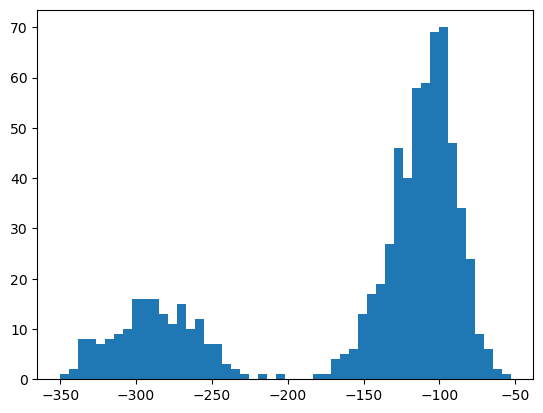

In [25]:
amplitudes = analyzer_TDC.get_extension("spike_amplitudes").get_data()
plt.hist(amplitudes, bins=50)
plt.show()

You can check which extensions have been saved (in your local folder) and which have been loaded (in your environment)...

In [26]:
print(analyzer_TDC.get_saved_extension_names())
print(analyzer_TDC.get_loaded_extension_names())

['correlograms', 'noise_levels', 'random_spikes', 'spike_amplitudes', 'spike_locations', 'templates', 'template_similarity', 'unit_locations', 'waveforms']
['random_spikes', 'waveforms', 'noise_levels', 'templates', 'spike_amplitudes', 'unit_locations', 'spike_locations', 'correlograms', 'template_similarity']


...or delete an extension...

In [27]:
analyzer_TDC.delete_extension("spike_amplitudes")

This deletes the extension's data in the `SortingAnalyzer` folder.

Importantly, `SortingAnalyzers` (and all extensions) can be reloaded at later times from their folders:
(Here, spike_amplitudes is not loaded since we just deleted it)

In [28]:
sorting_analyzer_path = './analyzer_TDC_binary'
analyzer_loaded = si.load_sorting_analyzer(sorting_analyzer_path)
print(analyzer_loaded.get_loaded_extension_names())

['correlograms', 'noise_levels', 'random_spikes', 'spike_locations', 'templates', 'template_similarity', 'unit_locations', 'waveforms']


And any deleted extensions are easily recomputed

In [29]:
analyzer_TDC.compute("spike_amplitudes")

spike_amplitudes:   0%|          | 0/10 [00:00<?, ?it/s]

Once we have computed all of the postprocessing information, we can compute quality
metrics (some quality metrics require certain extensions - e.g., drift metrics require `spike_locations`):

In [30]:
qm_params = sqm.get_default_qm_params()
pprint(qm_params)

{'amplitude_cutoff': {'amplitudes_bins_min_ratio': 5,
'histogram_smoothing_value': 3,
'num_histogram_bins': 100,
'peak_sign': 'neg'},  
'amplitude_cv': {'amplitude_extension': 'spike_amplitudes',
'average_num_spikes_per_bin': 50,
'min_num_bins': 10,
'percentiles': (5, 95)},
'amplitude_median': {'peak_sign': 'neg'},
'drift': {'direction': 'y',
'interval_s': 60,
'min_num_bins': 2,
'min_spikes_per_interval': 100},
'firing_range': {'bin_size_s': 5, 'percentiles': (5, 95)},
'firing_rate': {},
'isi_violation': {'isi_threshold_ms': 1.5, 'min_isi_ms': 0},
'nearest_neighbor': {'max_spikes': 10000, 'n_neighbors': 5},
'nn_isolation': {'max_spikes': 10000,
'min_fr': 0.0,    
'min_spikes': 10, 
'n_components': 10,
'n_neighbors': 4, 
'peak_sign': 'neg',
'radius_um': 100},
'nn_noise_overlap': {'max_spikes': 10000,
'min_fr': 0.0,        
'min_spikes': 10,     
'n_components': 10,   
'n_neighbors': 4,     
'peak_sign': 'neg',   
'radius_um': 100},    
'num_spikes': {},
'presence_ratio': {'bin_duration_

Since the recording is very short, let's change some parameters to accommodate the duration:

In [31]:
qm_params["presence_ratio"]["bin_duration_s"] = 1
qm_params["amplitude_cutoff"]["num_histogram_bins"] = 5
qm_params["drift"]["interval_s"] = 2
qm_params["drift"]["min_spikes_per_interval"] = 2

Quality metrics are extensions, so computations and data extraction work in the same way as earlier

In [32]:
analyzer_TDC.compute("quality_metrics", qm_params)
analyzer_TDC.get_extension("quality_metrics").get_data()

C:\Users\NTELAB\AppData\Roaming\Python\Python311\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:156: UserWarning: Bin duration of 60s is larger than recording duration. Presence ratios are set to NaN.
  warnings.warn(
C:\Users\NTELAB\AppData\Roaming\Python\Python311\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:908: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
C:\Users\NTELAB\AppData\Roaming\Python\Python311\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1064: UserWarning: The recording is too short given the specified 'interval_s' and 'min_num_bins'. Drift metrics will be set to NaN
  warnings.warn(


,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,...,amplitude_cv_median,amplitude_cv_range,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,drift_ptp,drift_std,drift_mad,sd_ratio
0,30,3.0,<NA>,27.084582,0,0,0,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,0.72,<NA>,<NA>,<NA>,1.536897
1,51,5.1,<NA>,24.079623,0,0,0,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,0.18,<NA>,<NA>,<NA>,1.311124
2,53,5.3,<NA>,23.972351,0,0,0,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,0.9,<NA>,<NA>,<NA>,2.01664
3,50,5.0,<NA>,26.843497,0,0,0,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,0.72,<NA>,<NA>,<NA>,2.01104
4,36,3.6,<NA>,9.55102,0,0,0,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,0.72,<NA>,<NA>,<NA>,0.680198
5,42,4.2,<NA>,13.16992,0,0,0,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,0.36,<NA>,<NA>,<NA>,0.965514
6,48,4.8,<NA>,8.285906,0,0,0,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,0.0,<NA>,<NA>,<NA>,1.177009
7,193,19.3,<NA>,8.740865,0,0,0,0,0.155,<NA>,...,<NA>,<NA>,0,0,0,2.34,<NA>,<NA>,<NA>,0.974257
8,129,12.9,<NA>,10.992369,0,0,0,0,0.31,<NA>,...,<NA>,<NA>,0,0,0,0.9,<NA>,<NA>,<NA>,0.949696
9,110,11.0,<NA>,8.285358,0,0,0,0,0.27,<NA>,...,<NA>,<NA>,0,0,0,2.16,<NA>,<NA>,<NA>,1.021078


And since the quality metrics are extensions, they are saved `SortingAnalyzer` folder.

Now, we can use some of the powerful tools for spike sorting visualization.

We can export a sorting summary and quality metrics plot using the `sortingview` backend. This will generate shareable links for web-based visualization.
For this to work you need to install `sortingview` and construct a `kachery-cloud`: [https://github.com/magland/sortingview](more details).

In [33]:
w1 = sw.plot_quality_metrics(analyzer_TDC, display=False, backend="sortingview")

C:\Users\NTELAB\AppData\Roaming\Python\Python311\site-packages\spikeinterface\widgets\metrics.py:65: UserWarning: Skipping ['presence_ratio', 'amplitude_cutoff', 'amplitude_cv_median', 'amplitude_cv_range', 'drift_ptp', 'drift_std', 'drift_mad'] because they contain all NaNs
  warnings.warn(f"Skipping {nan_metrics} because they contain all NaNs")


https://figurl.org/f?v=npm://@fi-sci/figurl-sortingview@12/dist&d=kachery:default:sha1:b205a6d906a98236dc9f88ffac9efc28eff993df&zone=default


In [34]:
w2 = sw.plot_sorting_summary(analyzer_TDC, display=False, curation=True, backend="sortingview")

https://figurl.org/f?v=npm://@fi-sci/figurl-sortingview@12/dist&d=kachery:default:sha1:8fba64e86469a7f9f29ccb4b9519d0fa48461567&zone=default


The sorting summary plot can also be used for manual labeling and curation. In the example above, we manually merged two units (0, 4) and added accept labels (2, 6, 7). After applying our curation, we can click on the "Save as snapshot (sha://)" and copy the URI:

In [35]:
uri = "sha1://4b13718ec2e59c0fdb0d0f89de0cd5b877aa704b"

sorting_curated_sv = scur.apply_sortingview_curation(sorting_TDC, uri_or_json=uri)
print(sorting_curated_sv)
print(sorting_curated_sv.get_property("accept"))

NumpySorting: 9 units - 1 segments - 32.0kHz
[ True  True  True  True  True  True  True  True  True]


Alternatively, we can export the data locally to Phy. [Phy](<https://github.com/cortex-lab/phy>) is a GUI for manual
curation of the spike sorting output. To export to phy you can run:

In [36]:
sexp.export_to_phy(analyzer_TDC, "phy_folder_for_TDC", verbose=True)

write_binary_recording:   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/10 [00:00<?, ?it/s]

Run:
 C:\Users\NTELAB\Downloads\Spikeinterface_test\phy_folder_for_TDC\params.py


Then you can run the template-gui with: `phy template-gui phy_folder_for_TDC/params.py`
and manually curate the results.

After curating with Phy, the curated sorting can be reloaded to SpikeInterface. In this case, we exclude the units that have been labeled as "noise":

In [37]:
sorting_curated_phy = se.read_phy("phy_folder_for_TDC", exclude_cluster_groups=["noise"])

Quality metrics can be also used to automatically curate the spike sorting
output. For example, you can select sorted units with a SNR above a
certain threshold:

In [38]:
qm_data = analyzer_TDC.get_extension("quality_metrics").get_data()
keep_mask = (qm_data["snr"] > 10) & (qm_data["isi_violations_ratio"] < 0.01)
print("Mask:", keep_mask.values)

sorting_curated_auto = sorting_TDC.select_units(sorting_TDC.unit_ids[keep_mask])
print(sorting_curated_auto)

Mask: <BooleanArray>
[True, True, True, True, False, True, False, False, True, False]
Length: 10, dtype: boolean
UnitsSelectionSorting: 6 units - 1 segments - 32.0kHz


The final part of this tutorial deals with comparing spike sorting outputs.
We can either:

1. compare the spike sorting results with the ground-truth
sorting `sorting_true`

2. compare the output of two sorters (e.g. Tridesclous and SpykingCircus2)

3. compare the output of multiple sorters (e.g. Tridesclous, SpykingCircus2, and Kilosort2)

In [39]:
comp_gt = sc.compare_sorter_to_ground_truth(gt_sorting=sorting_true, tested_sorting=sorting_TDC)
comp_pair = sc.compare_two_sorters(sorting1=sorting_TDC, sorting2=sorting_SC2)
comp_multi = sc.compare_multiple_sorters(
    sorting_list=[sorting_TDC, sorting_SC2, sorting_KS2], name_list=["tdc", "sc2", "ks2"]
)

When comparing with a ground-truth sorting (1,), you can get the sorting performance and plot a confusion
matrix

            accuracy    recall precision false_discovery_rate miss_rate
gt_unit_id                                                             
#0               1.0       1.0       1.0                  0.0       0.0
#1               1.0       1.0       1.0                  0.0       0.0
#2          0.976744  0.976744       1.0                  0.0  0.023256
#3               1.0       1.0       1.0                  0.0       0.0
#4               1.0       1.0       1.0                  0.0       0.0
#5          0.972973  0.972973       1.0                  0.0  0.027027
#6               1.0       1.0       1.0                  0.0       0.0
#7          0.990991  0.990991       1.0                  0.0  0.009009
#8          0.989744  0.989744       1.0                  0.0  0.010256
#9               1.0       1.0       1.0                  0.0       0.0


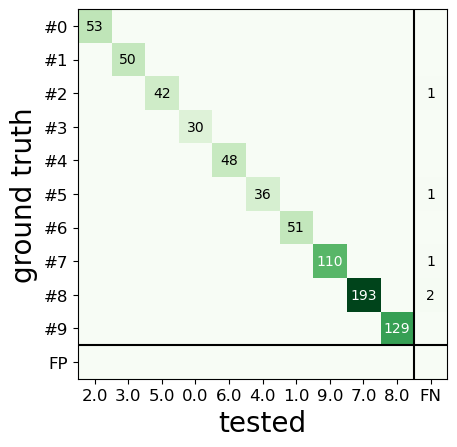

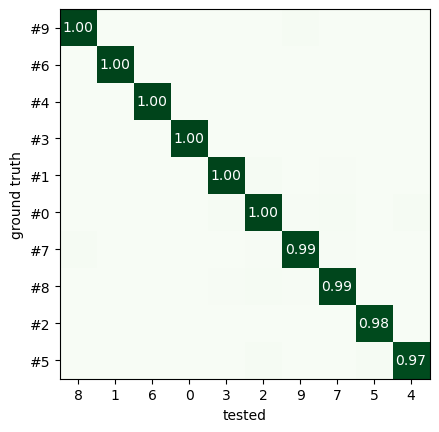

In [40]:
print(comp_gt.get_performance())
w_conf = sw.plot_confusion_matrix(comp_gt)
w_agr = sw.plot_agreement_matrix(comp_gt)

When comparing two sorters (2.), we can see the matching of units between sorters.
Units which are not matched have -1 as their unit id:

In [41]:
comp_pair.hungarian_match_12

0    -1.0
1    36.0
2    25.0
3    30.0
4     8.0
5    32.0
6    10.0
7    34.0
8    28.0
9    16.0
dtype: float64

or the reverse:

In [42]:
comp_pair.hungarian_match_21

1    -1.0
5    -1.0
8     4.0
9    -1.0
10    6.0
16    9.0
25    2.0
28    8.0
30    3.0
32    5.0
34    7.0
36    1.0
dtype: float64

When comparing multiple sorters (3.), you can extract a `BaseSorting` object with units in agreement
between sorters. You can also plot a graph showing how the units are matched between the sorters.

Units in agreement between TDC, SC2, and KS2: [0 1 2 3 4 5 6 7 8 9]


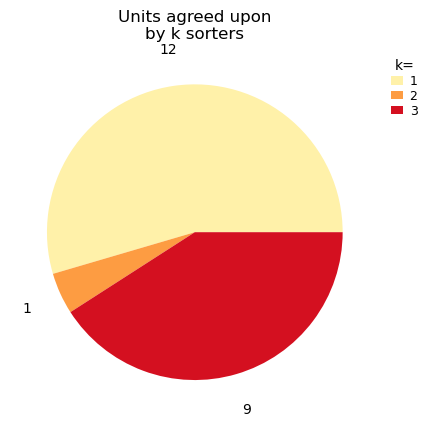

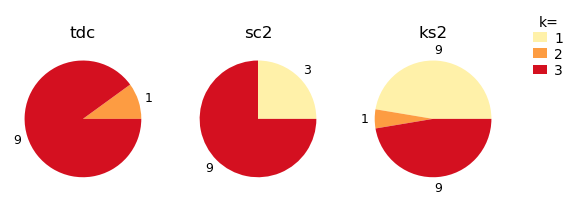

In [43]:
sorting_agreement = comp_multi.get_agreement_sorting(minimum_agreement_count=2)

print("Units in agreement between TDC, SC2, and KS2:", sorting_agreement.get_unit_ids())

w_multi = sw.plot_multicomparison_agreement(comp_multi)
w_multi = sw.plot_multicomparison_agreement_by_sorter(comp_multi)

We see that 10 unit were found by all sorters (note that this simulated dataset is a very simple example, and usually sorters do not do such a great job)!

However, Kilosort2 found 9 additional units that are not matched to ground-truth!

**That's all for this "How to get started" tutorial! Enjoy SpikeInterface!**